In [9]:
import numpy as np
import matplotlib.pyplot as plt


# This is an attempt at QMLE using the Newton-Raphson Algorithm.
We start by simulating a GARCH process by:
$$x_t = \sigma_t z_t, \qquad \sigma_t^2=\omega+\alpha x_{t-1} ^ 2 + \beta \sigma_{t-1}^2, \qquad z_t \sim i.i.d N(0,1)$$
First the basic Function for simulating this process, and the settings for the simulation.

In [142]:


# Settings: Set seed.
# np.random.seed(42)  # For reproducibility

#Draw parameters
omega_values = [0.01, 0.1]
alpha_values = [0.05, 0.25]
beta_values = [[0.6 - alpha, 1 - alpha] for alpha in alpha_values]


# Drawing parameters uniformly from the specified ranges

omega = np.random.uniform(low=0.01, high=0.1)

alpha = np.random.uniform(low=0.05, high=0.25)

beta = np.random.uniform(low=(0.6 - alpha), high=(1 - alpha))



def simulate_garch(T, omega, alpha, beta):
    """
    Simulates a GARCH(1,1) process.

    Parameters:
    - T: Number of observations.
    - omega: Constant term in the GARCH(1,1) model.
    - alpha: Coefficient for lagged squared innovations in the GARCH(1,1) model.
    - beta: Coefficient for lagged conditional variances in the GARCH(1,1) model.

    Returns:
    - x: Simulated asset returns (rt).
    - sigma: Conditional variances of the simulated asset returns (ht).
    """

    # Initialize arrays
    x = np.zeros(T)
    sigma = np.zeros(T)
    epsilon = np.random.normal(0, 1, T)

    # Assuming the unconditional variance for initialization
    sigma[0] = omega / (1 - alpha - beta)

    # Generate the GARCH(1,1) process
    for t in range(1, T):
        sigma[t] = omega + alpha * (epsilon[t-1]**2) + beta * sigma[t-1]
        x[t] = np.sqrt(sigma[t]) * epsilon[t]
     
    return x, sigma


def log_likelihood_function(parameters, returns):
    # Unpack Parameters
    omega, alpha, beta = parameters
    
    # Number of observations
    T = len(returns)
    
    # Pre-allocate h (conditional variances) with zeros
    sigma = np.zeros(T)
    
    # Initialize h[0] to the variance of the returns as a simple starting value
    sigma[0] = np.var(returns)
    
    # Calculate conditional variances h_t for t = 1 to T-1
    for t in range(1, T):
        sigma[t] = np.max((omega + alpha * (returns[t-1] ** 2) + beta * sigma[t-1],1e-6))
    
    # Calculate log likelihood contributions
    log_likelihood_contributions = -0.5 * np.log(2 * np.pi) - 0.5 * np.log(sigma) - 0.5 * (returns ** 2) / sigma
    
    # Sum to get total log likelihood
    total_log_likelihood = np.sum(log_likelihood_contributions)
    
    return total_log_likelihood


# Simulate Data

In [143]:
# Simulate the GARCH(1,1) process
num_obs = 1000  # Number of observations

x, sigma = simulate_garch(num_obs, omega, alpha, beta)


# Output the drawn parameters and the first 5 values of x and sigma

omega, alpha, beta, x[:5], sigma[:5]


(0.0638792635777333,
 0.0812037280884873,
 0.5811940800459937,
 array([ 0.        ,  0.47081024, -0.26987454,  0.28391505, -0.23028258]),
 array([0.1892146 , 0.37636471, 0.33044563, 0.27383011, 0.24693176]))

# Newton Raphson Algorithm:
The Algorithm is passed a function to maximize, the data, the initial guess and the bounds.

**Grid Search:** Could start with grid_search (If True, uses bounds, and takes a value, for how fine the grid is). 

- Can use ficed grid, alternating grid, random grid 

Taylor expansion



In [144]:
def Fit(objective_function, data, initial_guess=None, bounds=None, M=5, max_iterations=1000, tolerance=1e-4):
    # Setup of before the estimation
    
    theta, num_params, bounds, log_likelihood_history, parameter_history = setup(objective_function, data, initial_guess, M, bounds, max_iterations)
    epsilon = np.sqrt(np.finfo(float).eps)
    
    # The Main steps of the Algorithm:
    for iteration in range(max_iterations):
        print(iteration)
        # gradient = calculate_gradient(modified_objective_function, data, theta, epsilon)
        # Hessian = calculate_hessian(modified_objective_function, data, theta, epsilon)
        
        # # Solve for the update direction in transformed space
        # update_direction = np.linalg.solve(Hessian, -gradient)
        # theta += update_direction  # Update in transformed space
        

        # Calculate Gradient
        gradient = calculate_gradient(objective_function, data, theta, epsilon)
    
        # Calculate Hessian
        Hessian = calculate_hessian(objective_function, data, theta, epsilon)

        
        # Update Parameter histories, by np.linalg.solve for better numerical stability instead of directly inverting the Hessian
        update_direction = np.linalg.solve(Hessian, -gradient)
        theta += update_direction
        parameter_history[iteration,:] = theta
        # Check for convergence
        if np.linalg.norm(update_direction, ord=2) < tolerance:
            print(f"Convergence reached after {iteration+1} iterations.")
            break
    else:  # This else corresponds to the for-loop, executed if the loop completes normally without a break
        print(f"Maximum iterations reached without convergence.")
    
    
    # Transform parameters back if needed for interpretation or further calculations
    # actual_parameters = transform_parameters(theta)       
    return theta, # actual_parameters
    
# def transform_parameters(theta):
#     # Assuming theta contains the unconstrained versions of omega, alpha, beta
#     omega = np.exp(theta[0])  # Omega must be positive
#     alpha = np.exp(theta[1]) / (1 + np.exp(theta[1]) + np.exp(theta[2]))
#     beta = np.exp(theta[2]) / (1 + np.exp(theta[1]) + np.exp(theta[2]))
#     return np.array([omega, alpha, beta])

# def inverse_transform_parameters(omega, alpha, beta):
#     # This is more challenging because you need to find theta such that
#     # the transformations yield the original omega, alpha, beta
#     # This step is typically not needed for optimization, but might be useful for interpretation
#     # Placeholder for conceptual purposes
#     return np.array([np.log(omega), np.log(alpha / (1 - alpha - beta)), np.log(beta / (1 - alpha - beta))])

# def modified_objective_function(theta, data):
#     transformed_params = transform_parameters(theta)
#     return -log_likelihood_function(transformed_params, data)  # Negate for minimization

def setup(objective_function, data, initial_guess, M, bounds, max_iterations):
    """
    Creates the logic setup of the algoritm
        Parameter_estimates
        Log_likelihood_values
        Objective Function
        Initial Guess
        Bounds
    """
    # Create bounds
    if bounds is None:
        bounds = ((0,1),(0,1),(0,1))
        
    # Set Initial Parameter Guess
    if initial_guess is None:
        initial_guess, initial_log_likelihood = grid_search(objective_function, data, M, bounds)
    else: 
        initial_guess = initial_guess
        initial_log_likelihood = objective_function(initial_guess, data)
    # Store number of parameters for AIC & BIC 
    num_params = len(initial_guess)

    # set objective_function


    # Bounds?
    # Do nothing

    # Histories
    log_likelihood_history = np.zeros(max_iterations)
    log_likelihood_history[0] = initial_log_likelihood # Set the first log likelihood history
    # Parameter History
    parameter_history = np.zeros((max_iterations, num_params))
    parameter_history[0,:] = initial_guess 
    return initial_guess, num_params, bounds, log_likelihood_history, parameter_history



def grid_search(objective_function, data, M, bounds):
    """
        This function Creates a Grid using create_grid
        And then searches for the optimal starting values, based on the grid, using search_grid

        create_grid takes M, bounds, and creates a grid. 
            For bounds (A,B) it create M instances between A and B, uniformly distributed
            For bounds (A, None) it uses an exponential distribution, to have a finer mesh around A, and a coarser mesh, the further from A

        search_grid runs the objective_function, and tracks what value of the parameters leads to the largest log likelihood value.
            
    """
    # Create The Grid
    mesh_grid = create_grid(bounds, M)

    # Search The Grid
    initial_guess, initial_log_likelihood = search_grid(objective_function, data, mesh_grid)
    return initial_guess, initial_log_likelihood

def create_grid(bounds, M, focus_factor=5):
    """
    Create a grid for each parameter within the given bounds, with M values for each parameter.
    If a bound is (A, None), it creates a finer grid around A and a more coarse grid afterwards.

    :param bounds: List of tuples representing the bounds for each parameter. (min, max), with None indicating no bound.
    :param M: int, number of values for each parameter.
    :param focus_factor: int, factor by which the grid is finer around the specified start of the interval.
    :return: np.ndarray, grid for each parameter.
    """
    grids = []
    for min_val, max_val in bounds:
        if max_val is None:
            # Create a focused grid around min_val then expand coarsely
            # Use logarithmic spacing for the coarser part
            fine_grid_part = np.linspace(min_val, min_val * 2, M // focus_factor, endpoint=False)
            coarse_grid_part = np.logspace(np.log10(min_val * 2), np.log10(min_val * 10), M - len(fine_grid_part))
            grid = np.concatenate((fine_grid_part, coarse_grid_part))
        else:
            # Regular linear spacing
            grid = np.linspace(min_val, max_val, M)
        grids.append(grid)
    return np.meshgrid(*grids, indexing='ij')


def search_grid(objective_function, data, grid):
    """
    Perform a grid search over the specified parameter grid, evaluating the objective_function
    at each point and returning the parameters that maximize the objective function.

    :param objective_function: Callable, the objective function to maximize. It should take as many
                               arguments as there are parameters, and return a scalar value.
    :param grid: List of np.ndarrays, the grid of parameters generated by create_grid.
    :return: Tuple, the set of parameters that maximize the objective function and the maximum value.
    """
    max_value = float('-inf')
    best_params = None
    
    # Iterate over each point in the grid
    for index in np.ndindex(*grid[0].shape):
        # Extract the parameters for the current point
        params = [grid[i][index] for i in range(len(grid))]
        # Evaluate the objective function
        value = objective_function(params, data)
        # Update max_value and best_params if this point is better
        if value > max_value:
            max_value = value
            best_params = params
    
    return best_params, max_value


def calculate_gradient(objective_function, data, theta, epsilon):
    gradient = np.zeros_like(theta)
    for i in range(len(theta)):
        theta_plus = np.copy(theta)
        theta_minus = np.copy(theta)
        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon
        gradient[i] = (objective_function(theta_plus, data) - objective_function(theta_minus, data)) / (2 * epsilon)
    return(gradient)

def calculate_hessian(objective_function, data, theta, epsilon, regularization=1e-6):
    Hessian = np.zeros((len(theta), len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            theta_plus_plus = np.copy(theta)
            theta_plus_minus = np.copy(theta)
            theta_minus_plus = np.copy(theta)
            theta_minus_minus = np.copy(theta)
            
            theta_plus_plus[i] += epsilon
            theta_plus_plus[j] += epsilon
            
            theta_plus_minus[i] += epsilon
            theta_plus_minus[j] -= epsilon
            
            theta_minus_plus[i] -= epsilon
            theta_minus_plus[j] += epsilon
            
            theta_minus_minus[i] -= epsilon
            theta_minus_minus[j] -= epsilon
            
            Hessian[i, j] = (objective_function(theta_plus_plus,data) - objective_function(theta_plus_minus,data) - objective_function(theta_minus_plus,data) + objective_function(theta_minus_minus,data)) / (4 * epsilon**2)
    
    Hessian += np.eye(len(theta)) * regularization  # Regularization
    return Hessian


# The Log likleihood function for the model

In [155]:
# Simulate the GARCH(1,1) process
num_obs = 1000  # Number of observations
histogram = np.zeros((50, 3))

for i in range(50):
    omega = np.random.uniform(low=0.01, high=0.1)
    alpha = np.random.uniform(low=0.05, high=0.25)
    beta = np.random.uniform(low=(0.6 - alpha), high=(1 - alpha))
    histogram[i,0] = omega
    histogram[i,1] = alpha
    histogram[i,2] = beta
    x, sigma = simulate_garch(num_obs, omega, alpha, beta)
    

    # Output the drawn parameters and the first 5 values of x and sigma
    a = Fit(log_likelihood_function, x, M=3, max_iterations=100)
    histogram[i,:] = histogram[i,:] - a


0
1
Convergence reached after 2 iterations.
0
1
Convergence reached after 2 iterations.
0
1
2
3
Convergence reached after 4 iterations.
0
1
2
3
4
5
6
7
8
9
Convergence reached after 10 iterations.
0
1
2
3
4


/tmp/ipykernel_224362/806313866.py:66: RuntimeWarning: overflow encountered in scalar multiply
  sigma[t] = np.max((omega + alpha * (returns[t-1] ** 2) + beta * sigma[t-1],1e-6))
/tmp/ipykernel_224362/154037390.py:175: RuntimeWarning: invalid value encountered in scalar subtract
  gradient[i] = (objective_function(theta_plus, data) - objective_function(theta_minus, data)) / (2 * epsilon)
/tmp/ipykernel_224362/154037390.py:199: RuntimeWarning: invalid value encountered in scalar subtract
  Hessian[i, j] = (objective_function(theta_plus_plus,data) - objective_function(theta_plus_minus,data) - objective_function(theta_minus_plus,data) + objective_function(theta_minus_minus,data)) / (4 * epsilon**2)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Maximum iterations reached without convergence.
0
1
2
3
4
Convergence reached after 5 iterations.
0
1
2
3
Convergence reached after 4 iterations.
0
1
2
Convergence reached after 3 iterations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Maximum iterations reached without convergence.
0
1
2
Convergence reached after 3 iterations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
5

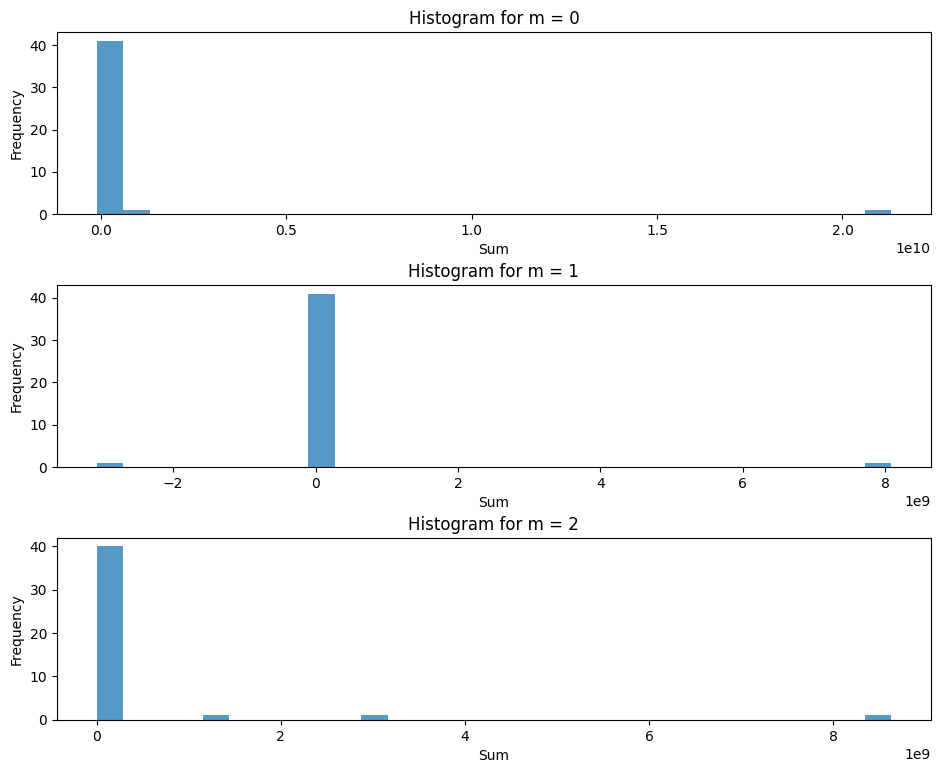

In [162]:

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
fig.tight_layout(pad=3.0)

for i in range(3):
    # Generate example histogram data for demonstration
    # Normally, you would fill histograms[i] with actual data


    axes[i].hist(histogram[:,i], bins=30, alpha=0.75)
    axes[i].set_title(f'Histogram for m = {i}')
    axes[i].set_xlabel('Sum')
    axes[i].set_ylabel('Frequency')

plt.show()

In [163]:
histogram

array([[-1.21099251e+08, -6.05496259e+07,  6.05496261e+07],
       [-6.26634168e-01, -5.61677249e+07,  7.53207505e-01],
       [ 7.79031843e-02,  2.45967438e-01, -3.39469850e-01],
       [ 2.13120000e+10,  1.17731373e+00,  3.01128130e+00],
       [            nan,             nan,             nan],
       [ 8.61857765e-02,  2.04444734e-01, -2.39845629e-01],
       [ 2.96056651e-02,  5.16996461e-02, -3.25187861e-01],
       [ 1.43176074e-02,  9.80654256e-02, -4.53067982e-01],
       [            nan,             nan,             nan],
       [ 4.32040142e-02,  1.36462322e-01, -3.34392723e-01],
       [            nan,             nan,             nan],
       [-6.95966126e-02, -4.53100482e-01,  2.55525184e-01],
       [-9.15332058e-01, -5.11291991e-01,  7.39479521e-01],
       [ 8.87554828e-02,  1.46616607e-01, -4.82809051e-01],
       [ 4.53310178e-01, -6.04713202e-01,  8.62975000e+09],
       [ 4.83575278e-02,  9.32997775e-02, -1.54489400e-01],
       [            nan,             nan

In [89]:
np.exp(omega+1e-1)

1.1545476366731633

In [85]:
np.exp(alpha)

1.2714307755780394

In [86]:
np.exp(beta)

1.92063280071104